#### Marsh Erosion

This is one approach to book-keeping for modeling marsh edges that are not well resolved by the grid. It has the following properties.
* Conserves mass while eroding the marsh edge and supplying sediment to the adjacent tidal flat.
* Models erosion as a marsh-edge scarp retreat rate.
* Maintains elevation on top of marsh, and
* Has a mechanism for converting eroded marsh cells to wet tidal flat cells.
* Tracks fraction of marsh cell that has eroded.
* Tracks face elevation of marsh-edge scarp.

![Definition sketch](marsh_sketch.png)

* ```dx, dy, dz``` = dimensions of marsh cell (m)
* ```V``` = volume of marsh cell (m^3)
* ```M``` = mass of sediment in marsh cell (kg), intitially ```(1-cb)*rhos*V```
    where 1-cb is porosity, cb is bed fraction and rhos is sediment particle density
* ```xm``` = cumulative distance of marsh retreat (m), initially 0.  ```0 <= xm <= dx```
* ```zm``` = height of marsh scarp, determined by marsh elevation minus elevation of adjacent tidal flat cell

The only new variables that needs to be stored are ```xm```, a marsh mask, and a *marsh fraction* (see below).

Marsh cells are initially all marsh, and are masked as *dry* and *marsh*. The marsh retreat rate is calculated from wave impact, and the distance of retreat for a time step is calculated. The corresponding mass eroded is determined and removed from the marsh cell. Here, that mass is added to the adjacent tidal flat cell, but it might be better to add it to the adjacent water column, where it would be more likely to settle or diffuse correctly. The variable ```xm``` tracks the distance of marsh retreat in a time step. This can be combined with the cell size ```dx``` to calculate ```xm/dx```, the horizontal fraction of the cell that has eroded. The amount of marsh remaining is the *marsh fraction*  ```fmh = 1-xm/dx```. While any marsh remains (```fmh > 0```), the elevation of the marsh does not decrease as the mass of sediment in the cell decreases, but can be increased by deposition or growth, which is not included here.

The height of the marsh-face scarp ```zm``` is determined after each time step as the difference between the marsh elevation and the elevation of the adjacent wet tidal-flat cell. This height is used with ```xm``` to determine the volume (and then mass) of sediment eroded when the marsh retreats.

The distance of retreat in a time step cannot exceed the remaining distance. When the marsh fraction ```fmh``` reaches zero, the marsh is collapsed to a lower elevation and masked as *wet* and *not marsh*. The elevation ```dz``` of the collapsed marsh is determined from the mass of sediment and the original bulk porosity as ```dz = M/((1-cb)*rhos*dx*dy)```.

Open questions:
* Is this the best elevation for the marsh collapse to? Here, it is lower than the adjacent tidal flat elevation.
* Where is the best place to put the eroded sediment? Maybe distributed in the water column?
* Should we use ```fmh``` as the marsh mask? It will be a floating point number between 0. and 1.

This example is 1DH, with erosion in one direction, but it can be implemented in 2DH. Incorporation of stratigraphy will complicate the book-keeping, but is feasible.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Initialize

# cell size
dx = 10.
dy = 10.

rhos = 2650.
cb = .5

# thickness of cells
dz = np.array([2.,2.,2.,2.,2.,3.,3.,3.,3.,3.])

# cumulative erosion so far (none)
xm = np.zeros_like(dz)

nx = len(dz)

# marsh mask
mmask = np.array([0.,0.,0.,0.,0.,1.,1.,1.,1.,1.])

# location of left side of cells
xl = dx*np.arange(nx)
# location of center of cells
xc = np.cumsum(np.arange(nx)*dx)

# initial scarp elevations (these are located on left edge, so need to add one for first cell)
zm = mmask*np.append(np.array([0.]),np.diff(dz))

tt = 50*24.*3600.       # 50 days
dt = 24.*3600.          # dt = 1 day
nt = int(np.ceil(tt/dt))

# cell volumes
V = dx*dy*dz

# sediment mass in each cell
M = rhos*(1-cb)*V

# total sediment mass in system
sumM = np.sum(M)

# horiz marsh fraction
fmh = (1. - (xm/dx)*mmask)

# declare arrays for storing output
dz_a = np.nan*np.ones((nt,nx))
M_a =  np.nan*np.ones((nt,nx))


# Run
for i in range(nt):
    
    # calculate erosion distance (constant at 300 m/yr = 0.82 m/day)
    dxm = dt*300./(3600.*24.*365.)*(np.abs(zm)>0.)
    
    # ensure that cumulative scarp erosion does not exceed dx
    for j in range(nx):
        if (dxm[j]+xm[j])>dx :
            dxm[j]=dx-xm[j]       
    
    # increment cumulative scarp erosion distance
    xm += dxm
    
    # calc eroded mass from volume of scarp erosion
    dM = rhos*(1-cb)*dxm*dy*zm
    
    # subtract mass from eroding marsh cell
    M -= dM
    
    # add mass to cell to left (or water column)
    M[0:-1] += dM[1:]
    
    # update volumes
    V = M/(rhos*(1-cb))

    # if there is deposition, the additional cell height should be 
    # based on the (remaining) horizonal area of marsh
    # update dz
        
    # update horiz marsh cell fraction
    fmh = (1. - (xm/dx)*mmask)
    
    # Criteria to use for marsh mask:
    # If there is any horizontal fraction left, and it was marsh, it is still marsh.
    # (one-way...does not generate new marsh)
    mmask = np.ceil(fmh)*mmask

    # collapse the elevation of new non-marsh cells
    for j in range(nx):
        if (mmask[j]<=0.5) :
            dz[j]=V[j]/(dx*dy)

        
    # recalculate scarp heights
    zm = mmask*np.append(np.array([0.]),np.diff(dz))
                   
    # update vertical marsh cell fraction
    fmv = (1. - (zm/dz)*mmask)
    
    # update total marsh cell fraction
    fm = (1.-(xm/dx+zm/dz)*mmask)
   
    # store results for each time step
    dz_a[i,:]=dz
    M_a[i,:]=M


Total sediment mass in model: [ 3312500.  3312500.  3312500.  3312500.  3312500.  3312500.  3312500.
  3312500.  3312500.  3312500.  3312500.  3312500.  3312500.  3312500.
  3312500.  3312500.  3312500.  3312500.  3312500.  3312500.  3312500.
  3312500.  3312500.  3312500.  3312500.  3312500.  3312500.  3312500.
  3312500.  3312500.  3312500.  3312500.  3312500.  3312500.  3312500.
  3312500.  3312500.  3312500.  3312500.  3312500.  3312500.  3312500.
  3312500.  3312500.  3312500.  3312500.  3312500.  3312500.  3312500.
  3312500.]


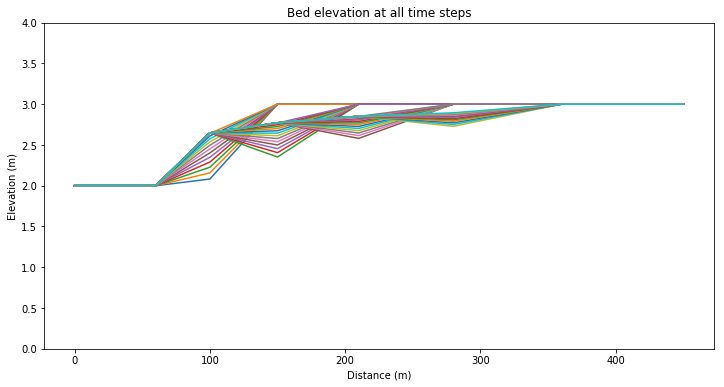

In [3]:
plt.figure(figsize=(12,6))
for i in range(nt):
    plt.plot(xc,dz_a[i][:])
    plt.ylim((0.,4))
    plt.ylabel('Elevation (m)')
    plt.xlabel('Distance (m)')
    plt.title('Bed elevation at all time steps')
    
print("Total sediment mass in model:",np.sum(M_a,1))